### Import Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
import seaborn as sns

### Dataset Path Declaration

In [2]:
dataset_path=r"D:\Personal\Capstone\Datasets\PKLot\Dataset\Cloudy"
class_path=[os.path.join(dataset_path, folder) for folder in os.listdir(dataset_path)]

### Image Preprocessing

In [3]:
images=[]
labels=[]
class_mapper={
    "Empty":0,
    "Occupied":1
}
for cls in class_path:
    print(f"Started: {os.path.basename(cls)}")
    for file in os.listdir(cls):
        image_path=os.path.join(cls,file)
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(64,64))
        image=image/255.0
        images.append(image)
        labels.append(class_mapper[os.path.basename(cls)])
    print("Finished")

images=np.array(images)
labels=np.array(labels)

Started: busy
Finished
Started: free
Finished


In [4]:
from collections import Counter
c=Counter(labels)
c

Counter({0: 3621, 1: 2550})

Number of classes:  2
Number of images in busy class:3621
Number of images in free class:2550


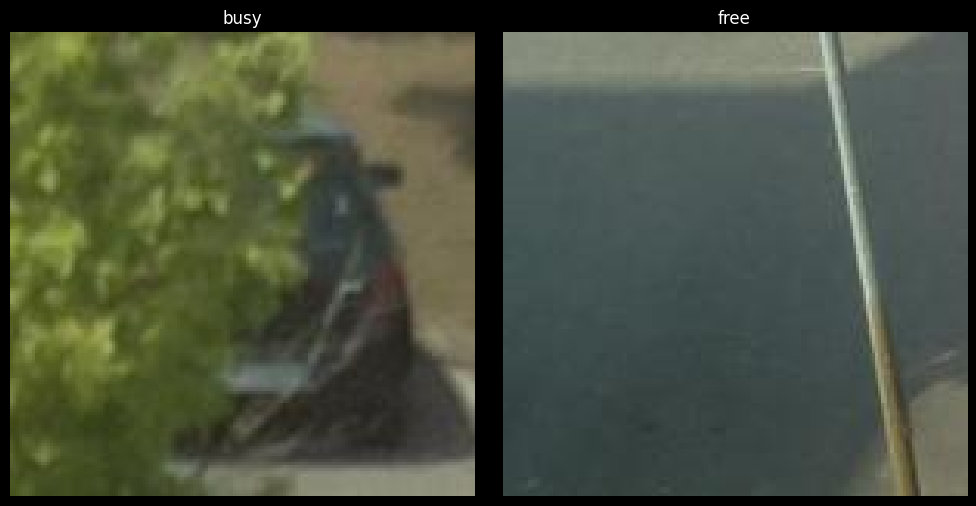

In [5]:
print("Number of classes: ", len(os.listdir(dataset_path)))
for cls in class_path:
    print(f"Number of images in {os.path.basename(cls)} class:"+str(len((os.listdir(cls)))))

fig,axis=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axis=axis.flatten()
for cls,ax in zip(class_path,axis):
    random_image_path=os.path.join(cls,np.random.choice(os.listdir(cls)))
    random_image=plt.imread(random_image_path)
    ax.imshow(random_image)
    ax.axis('off')
    ax.set_title(os.path.basename(cls))
plt.tight_layout()
plt.show()

### Train Test Split

In [6]:
x_train, x_test, y_train, y_test=train_test_split(images,labels,test_size=0.2,random_state=100)

### Creating a sequential CNN model

In [7]:
def cnn_model(image_size):
    model=Sequential()
    #Input Layer
    model.add(Input(shape=(image_size),name='input_layer'))

    #Block 1:
    model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',name='conv_layer_1'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='maxpooling_layer_1'))
    model.add(Dropout(0.25,name="dropout_layer_1"))

    #Block 2:
    model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',name='conv_layer_2'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='maxpooling_layer_2'))
    model.add(Dropout(0.25,name="dropout_layer_2"))

    #Block 3:
    model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',name='conv_layer_3'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='maxpooling_layer_3'))
    model.add(Dropout(0.25,name="dropout_layer_3"))

    #Flatten
    model.add(Flatten(name='flatten'))

    #Dense Layer
    model.add(Dense(64,activation='relu',name='dense_1'))
    model.add(Dense(32,activation='relu',name='dense_2'))
    model.add(Dense(1,activation='sigmoid',name='dense_3'))
    return model

In [8]:
model=cnn_model((64,64,3))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer_1 (Conv2D)       (None, 62, 62, 16)        448       
                                                                 
 maxpooling_layer_1 (MaxPoo  (None, 31, 31, 16)        0         
 ling2D)                                                         
                                                                 
 dropout_layer_1 (Dropout)   (None, 31, 31, 16)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 29, 29, 32)        4640      
                                                                 
 maxpooling_layer_2 (MaxPoo  (None, 14, 14, 32)        0         
 ling2D)                                                         
                                                                 
 dropout_layer_2 (Dropout)   (None, 14, 14, 32)      

### Training Images

In [9]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history=model.fit(x_train,y_train,
                  callbacks=[early_stopping],
                  epochs=10,
                  batch_size=32, 
                  validation_split=0.2)

Epoch 1/10


124/124 [==============================] - 5s 28ms/step - loss: 0.2573 - accuracy: 0.8782 - val_loss: 0.1196 - val_accuracy: 0.9656
Epoch 2/10
124/124 [==============================] - 3s 24ms/step - loss: 0.0573 - accuracy: 0.9787 - val_loss: 0.0683 - val_accuracy: 0.9929
Epoch 3/10
124/124 [==============================] - 3s 23ms/step - loss: 0.0247 - accuracy: 0.9916 - val_loss: 0.0508 - val_accuracy: 0.9939
Epoch 4/10
124/124 [==============================] - 3s 23ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0457 - val_accuracy: 0.9879
Epoch 5/10
124/124 [==============================] - 3s 22ms/step - loss: 0.0253 - accuracy: 0.9911 - val_loss: 0.0474 - val_accuracy: 0.9939
Epoch 6/10
124/124 [==============================] - 3s 22ms/step - loss: 0.0172 - accuracy: 0.9942 - val_loss: 0.0788 - val_accuracy: 0.9848
Epoch 7/10
124/124 [==============================] - 3s 22ms/step - loss: 0.0091 - accuracy: 0.9975 - val_loss: 0.0196 - val_accuracy: 0.99

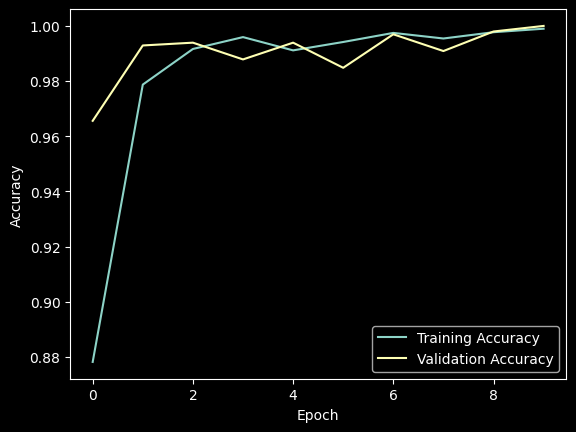

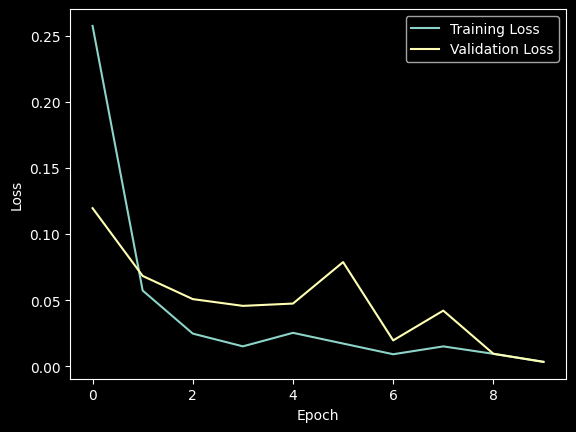

In [10]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing and validation

In [11]:
prediction=model.predict(x_test)
predicted_classes = (prediction > 0.5).astype("int32")

39/39 [==============================] - 0s 7ms/step


0.9983805668016195

In [14]:
accuracy=accuracy_score(y_test,predicted_classes)
precision=precision_score(y_test,predicted_classes)
f1_score=f1_score(y_test,predicted_classes)
print(f"Accuracy:{accuracy}\nPrecision:{precision}\nF1 Score:{f1_score}")

Accuracy:0.9983805668016195
Precision:0.998046875
F1 Score:0.998046875


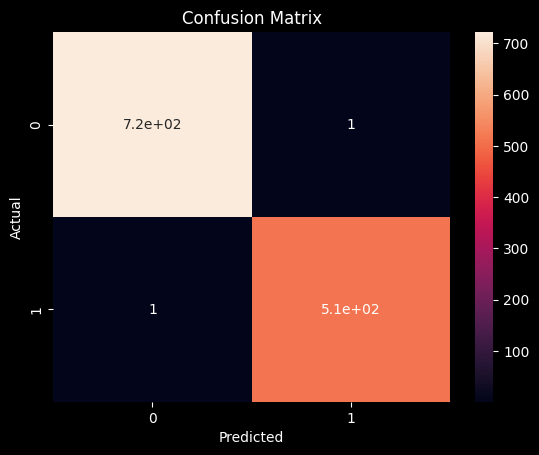

In [12]:
cm=confusion_matrix(y_test,predicted_classes)
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
model.save(r'D:\Personal\Capstone\custom_cnn\cnn_model_1.keras')